In [8]:
import os
import sys
import torch
import random
import argparse
import numpy as np
import scipy
from matplotlib import pyplot
import numpy

sys.path.append('../../timeseries/')
sys.path.append('../../timeseries/experiments_scripts/')
sys.path.append('../../src/')

import factors
import state_models
import observation_models
from ssm_em import StateSpaceEM
from nonlinear_ssm import NonLinearStateSpace_EM

from scipy.stats import norm
from scipy.stats import zscore
from ssm_em import StateSpaceEM, load_model
from sklearn.covariance import EmpiricalCovariance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

from exp_utils import *
import ssm
import statsmodels.api as sm

'''
sys.path.append('../../timeseries/kalman-jax-master')
from jax.experimental import optimizers
#from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, plot
'''


class PredictiveDensity:
    def __init__(self, mu, sigma):
        if mu.ndim == 1:
            self.mu = np.array([mu]).T
        else:
            self.mu = np.array(mu)
        if sigma.ndim == 1:
            self.Sigma = np.array([sigma]).T
        else:    
            self.Sigma = np.array(sigma)
            
def reset_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def train_linear_SSM(x_tr, dz, init_w_pca=False, smooth_window=20):

    dx = x_tr.shape[1]
    sm = state_models.LinearStateModel(dz)
    om = observation_models.LinearObservationModel(dx, dz, noise_x=1.)
    
    if init_w_pca == 1:
        om.pca_init(x_tr, smooth_window=smooth_window)
        
    ssm_em_lin = StateSpaceEM(x_tr, observation_model=om, state_model=sm)
    ssm_em_lin.run()
    
    return ssm_em_lin


def train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=False, smooth_window=20):

    dx = x_tr.shape[1]
    sm_hs = state_models.LinearStateModel(dz)
    om_hs = observation_models.HCCovObservationModel(dx, dz, du)
    if init_w_pca == 1:
        om_hs.pca_init(x_tr, smooth_window=20)
    hs_model = StateSpaceEM(x_tr, observation_model=om_hs, state_model=sm_hs, conv_crit=1e-4)
    hs_model.run()
    
    return hs_model

def train_nonlinear_SSM(x_tr, **kwargs):
    '''
    to be updated; currently doesn't run
    LSEMStateModel -> sm_hs = state_models.LSEMStateModel(args.dz,args.dk# + param for basis func)
    '''
    nonlin_model = NonLinearStateSpace_EM(x_tr,args.dz, args.dk)
    nonlin_model.run()
    
    return nonlin_model

class HMM_class:
    
    def __init__(self, x_tr, K, obs_model='gaussian'):
        self.x_tr = x_tr
        self.D = x_tr.shape[1]
        self.K = K
        self.obs_model = obs_model
        self.model = self._train()
        
    def _train(self):
        model = ssm.HMM(self.K, self.D, observations=self.obs_model)
        model.fit(self.x_tr, method="em")
        return model

    def compute_predictive_log_likelihood(self, x_te):
        return self.model.log_likelihood(x_te)
    
    def compute_predictive_density(self, x_te):
        mask = np.logical_not(np.isnan(x_te))
        x_te_not_nan = np.zeros(x_te.shape)
        x_te_not_nan[mask] = x_te[mask]
        states = self.model.filter(x_te_not_nan, mask=mask)
        if self.obs_model == 'gaussian' or  self.obs_model == 'studentst':
            mean_te = np.dot(states, self.model.observations.mus)
        elif self.obs_model == 'ar':
            mean_te = np.sum(states[:,:,None] * (np.sum(self.model.observations.As[None] * x_te[:,None, None], axis=3) + self.model.observations.bs), axis=1)
        std_te = np.dot(states, np.sqrt(self.model.observations.Sigmas.diagonal(axis1=1, axis2=2)))
        print(mean_te.shape, std_te.shape)
        return PredictiveDensity(mean_te, std_te ** 2)

def train_HMM(x_tr, num_states, **kwargs):
    return HMM_class(x_tr, num_states)


class ARIMAX:
    
    def __init__(self, x_tr, p, q):
        self.x_tr = x_tr
        self.p = p
        self.q = q
        self._train()
        
    def _train(self):
        if x_tr.shape[1] == 1:
            self.mod = sm.tsa.statespace.SARIMAX(x_tr, trend='c', order=(self.p,0,self.q))
            self.fit_res = self.mod.fit(disp=False)
        else:
            self.mod = sm.tsa.VARMAX(x_tr, trend='c', order=(self.p,self.q))
            self.fit_res = self.mod.fit(disp=False, max_iter=1000)
            
    def compute_predictive_density(self, x_te):
        mod_te = self.mod.clone(x_te)
        res = mod_te.filter(self.fit_res.params)
        predict = res.get_prediction()
        predict_ci = predict.conf_int(alpha=1.-.68)
        mu = predict.predicted_mean
        if x_te.shape[1] == 1:
            std = predict.predicted_mean - predict_ci[:,0]
        else:
            std = predict.predicted_mean - predict_ci[:,:x_te.shape[1]]
        return PredictiveDensity(mu, std ** 2)
            
    def compute_predictive_log_likelihood(self, x_te):  
        mod_te = self.mod.clone(x_te)
        return mod_te.loglike(self.fit_res.params)
    
def train_arimax(x_tr, p, q):
    
    arimax_model = ARIMAX(x_tr, p, q)
    return arimax_model

In [11]:
seed = 0
reset_seeds(seed)
p, q = 1, 1
x_tr, x_va, x_te, x_te_na, s_tr_x = load_sunspots_e1(train_ratio=.75)
arimax = train_arimax(x_tr, p, q)
arimax.compute_predictive_log_likelihood(x_te)

-480.8407513127301

In [4]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_sunspots_e1()
ssm_em_lin = train_linear_SSM(x_tr, dz, init_w_pca=False)
ssm_em_lin.save(model_name='ssm_em_lin_sunspots', path='../../data/models/')

Iteration 2 - llk=-1163.8
Iteration 4 - llk=-729.2
Iteration 6 - llk=-641.1
Iteration 8 - llk=-631.9
Iteration 10 - llk=-630.3
EM did converge.


In [7]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_sunspots_e1()
ssm_em_hsk = train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=False)
ssm_em_hsk.save(model_name='ssm_em_hsk_sunspots', path='../../data/models/')

Iteration 2 - llk=-724.0
Iteration 4 - llk=-631.8
Iteration 6 - llk=-571.7
Iteration 8 - llk=-532.6
Iteration 10 - llk=-510.5
Iteration 12 - llk=-497.6
Iteration 14 - llk=-490.2
Iteration 16 - llk=-486.0
Iteration 18 - llk=-483.8
Iteration 20 - llk=-482.6
EM did converge.


In [ ]:
ssm_em_hsk = load_model(model_name='ssm_em_hsk_energy', path='../../data/models/')
ssm_em_lin = load_model(model_name='ssm_em_lin_energy', path='../../data/models/')

In [8]:
ssm_em_lin.compute_predictive_log_likelihood(x_te)

-735.9396562519788

In [9]:
ssm_em_hsk.compute_predictive_log_likelihood(x_te)

-602.7851034664313

In [10]:
pred_hsk = ssm_em_hsk.compute_predictive_density(x_te)
pred_lin = ssm_em_lin.compute_predictive_density(x_te)

Text(0.5, 0, 'Time steps')

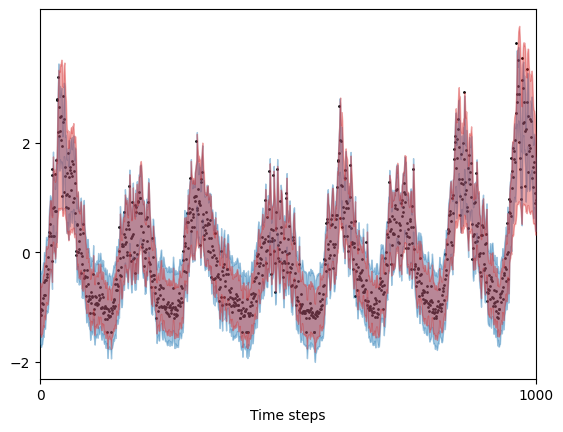

In [13]:
pyplot.rcdefaults()
mu_hsk, std_hsk = pred_hsk.mu, numpy.sqrt(pred_hsk.Sigma.diagonal(axis1=1, axis2=2))
mu_lin, std_lin = pred_lin.mu, numpy.sqrt(pred_lin.Sigma.diagonal(axis1=1, axis2=2))

fig = pyplot.figure()
for idx in range(1):
    ax = fig.add_subplot(1,1,idx+1)
    pyplot.plot(x_te[10:1010,idx], 'k.', ms=2)
    pyplot.fill_between(range(1000), mu_hsk[10:1010,idx] - 1.68 * std_hsk[10:1010,idx], mu_hsk[10:1010,idx] + 1.68 * std_hsk[10:1010,idx], color='C3', alpha=.4, zorder=9, label='heterosk.')
    pyplot.fill_between(range(1000), mu_lin[10:1010,idx] - 1.68 * std_lin[10:1010,idx], mu_lin[10:1010,idx] + 1.68 * std_lin[10:1010,idx], color='C0', alpha=.4, zorder=7, label='homosk.')
    pyplot.xlim([0,1000])
    pyplot.xticks([0,1000], labels=[])
    pyplot.yticks([-2,0,2])
    #pyplot.ylim([-3,3])
pyplot.xticks([0,1000], labels=[0,1000])
#pyplot.legend(frameon=False)
idx = 2
pyplot.xlabel('Time steps')
#pyplot.plot(mu_hsk[:1000,idx], color='C0')
#pyplot.plot(mu_hsk[:1000,idx], color='C3')